In [1]:
from pathlib import Path
import sys
 
if sys.argv:
    sys.path.insert(0, str(Path('/Users/ogrobertino/UpliftModelingResearch/').resolve()))
%load_ext autoreload
%autoreload 2

In [2]:
from src.global_params import *
from src.models.CausalML.Models import TModel
import pandas as pd
table = pd.read_csv(BASE_PATH + "/exps/stats.tsv", sep='\t')

path = table[table.Model == "TModel"].sort_values(by=["AUUC (test)"], ascending=False).Path.iloc[0]
model = TModel(from_load=True, path = str(BASE_PATH) + "/" + path)
y = pd.read_csv(str(BASE_PATH) + '/' + path +'/predictions.tsv', sep='\t')

Failed to import duecredit due to No module named 'duecredit'


Model loaded from /Users/ogrobertino/UpliftModelingResearch/exps/lazada/100/21/model.pkl.
Config loaded from /Users/ogrobertino/UpliftModelingResearch/exps/lazada/100/21/config.json.


In [3]:
from src.utils import get_auuc
from causalml.metrics import auuc_score, plot_gain
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

In [4]:
uplift_auc_score(y.target, y.score, y.treatment)

0.0035236955482630897

In [5]:
# from sklift.viz import plot_uplift_curve

from sklift.metrics import (
    uplift_curve, perfect_uplift_curve, uplift_auc_score,
    qini_curve, perfect_qini_curve, qini_auc_score,
    treatment_balance_curve, uplift_by_percentile
)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
def plot_uplift_curve(y_true, uplift, treatment,
                      random=True, perfect=True, ax=None, name=None, **kwargs):
    """Plot Uplift curves from predictions.

    Args:
        y_true (1d array-like): Ground truth (correct) binary labels.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
        random (bool): Draw a random curve. Default is True.
        perfect (bool): Draw a perfect curve. Default is True.
        ax (object): The graph on which the function will be built. Default is None.
        name (string): The name of the function. Default is None.

    Returns:
        Object that stores computed values.

    Example::

        from sklift.viz import plot_uplift_curve


        uplift_disp = plot_uplift_curve(
            y_test, uplift_predicted, trmnt_test,
            perfect=True, name='Model name'
        );

        uplift_disp.figure_.suptitle("Uplift curve");
    """
    # check_matplotlib_support('plot_uplift_curve')
    # check_consistent_length(y_true, uplift, treatment)
    # check_is_binary(treatment)
    # check_is_binary(y_true)

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)
    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)

    if random:
        x_baseline, y_baseline = x_actual, x_actual * y_actual[-1] / len(y_true)
    else:
        x_baseline, y_baseline = None, None

    if perfect:
        x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    else:
        x_perfect, y_perfect = None, None

    viz = UpliftCurveDisplay(
        x_actual=x_actual,
        y_actual=y_actual,
        x_baseline=x_baseline,
        y_baseline=y_baseline,
        x_perfect=x_perfect,
        y_perfect=y_perfect,
        random=random,
        perfect=perfect,
        estimator_name=name,
    )

    auc = uplift_auc_score(y_true, uplift, treatment)

    return viz.plot(auc, ax=ax, title="AUC", **kwargs)

class UpliftCurveDisplay:
    """Qini and Uplift curve visualization.

    Args:
        x_actual, y_actual (array (shape = [>2]), array (shape = [>2])): Points on a curve
        x_baseline, y_baseline (array (shape = [>2]), array (shape = [>2])): Points on a random curve
        x_perfect, y_perfect (array (shape = [>2]), array (shape = [>2])): Points on a perfect curve
        random (bool): Plotting a random curve
        perfect (bool): Plotting a perfect curve
        estimator_name (str): Name of estimator. If None, the estimator name is not shown.
    """

    def __init__(self, x_actual, y_actual, x_baseline=None,
                 y_baseline=None, x_perfect=None, y_perfect=None,
                 random=None, perfect=None, estimator_name=None):
        self.x_actual = x_actual
        self.y_actual = y_actual
        self.x_baseline = x_baseline
        self.y_baseline = y_baseline
        self.x_perfect = x_perfect
        self.y_perfect = y_perfect
        self.random = random
        self.perfect = perfect
        self.estimator_name = estimator_name

    def plot(self, auc_score, ax=None, name=None, title=None, **kwargs):
        """Plot visualization

        Args:
            auc_score (float): Area under curve.§
            ax (matplotlib axes): Axes object to plot on. If `None`, a new figure and axes is created. Default is None.
            name (str): Name of ROC Curve for labeling. If `None`, use the name of the estimator. Default is None.
            title (str): Title plot. Default is None.

        Returns:
            Object that stores computed values
        """
        # check_matplotlib_support('UpliftCurveDisplay.plot')

        name = self.estimator_name if name is None else name

        line_kwargs = {}
        if auc_score is not None and name is not None:
            line_kwargs["label"] = f"{name} ({title} = {auc_score:0.2f})"
        elif auc_score is not None:
            line_kwargs["label"] = f"{title} = {auc_score:0.2f}"
        elif name is not None:
            line_kwargs["label"] = name

        line_kwargs.update(**kwargs)

        if ax is None:
            fig, ax = plt.subplots()

        self.line_, = ax.plot(self.x_actual, self.y_actual, **line_kwargs)

        if self.random:
            ax.plot(self.x_baseline, self.y_baseline, label="Random")
            ax.fill_between(self.x_actual, self.y_actual, self.y_baseline, alpha=0.2)

        if self.perfect:
            ax.plot(self.x_perfect, self.y_perfect, label="Perfect")

        ax.set_xlabel('Number targeted')
        ax.set_ylabel('Number of incremental outcome')

        if self.random == self.perfect:
            variance = False
        else:
            variance = True

        if len(ax.lines) > 4:
            ax.lines.pop(len(ax.lines) - 1)
            if variance == False:
                ax.lines.pop(len(ax.lines) - 1)

        if "label" in line_kwargs:
            ax.legend(loc=u'upper left', bbox_to_anchor=(1, 1))

        self.ax_ = ax
        self.figure_ = ax.figure

        return self

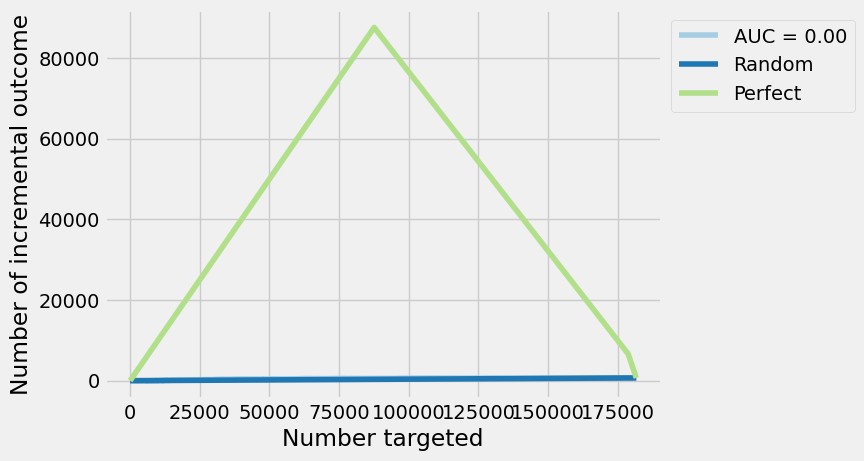

In [19]:
plot_uplift_curve(
    y.target, y.score, y.treatment,
    perfect=True
)

почему так - https://github.com/maks-sh/scikit-uplift/issues/93#issuecomment-1209798947

In [ ]:
auuc_score(

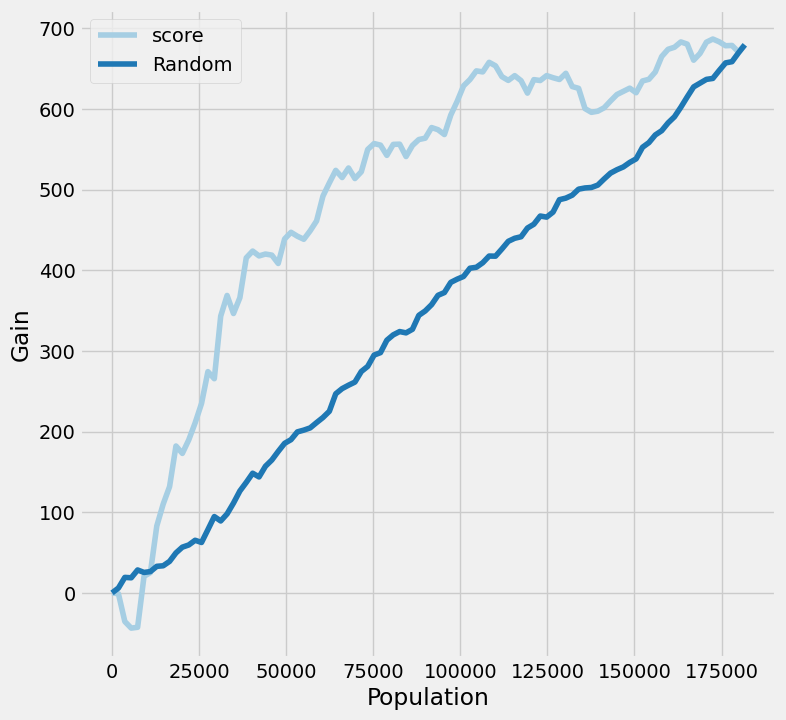

In [21]:
plot_gain(y, outcome_col=COL_TARGET, treatment_col=COL_TREATMENT)

In [28]:
qini_auc_score(y.target, y.score, y.treatment)

0.024982500147084995

In [4]:
uplift_auc_score(y.target, y.score, y.treatment)

0.0035236955482630897

In [5]:
auuc_score(y, outcome_col=COL_TARGET, treatment_col=COL_TREATMENT)

score     0.730708
Random    0.495192
dtype: float64

In [6]:
auuc_score(y, outcome_col=COL_TARGET, treatment_col=COL_TREATMENT, normalize=False)

score     496.431994
Random    336.425698
dtype: float64

In [7]:
y_true = y.target
treatment = y.treatment

In [9]:
import numpy as np
cr_num = np.sum((y_true == 1) & (treatment == 0)) # Control   Responders
tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders
summand = y_true if cr_num > tn_num else treatment
perfect_uplift = 2 * (y_true == treatment) + summand

In [20]:
perfect_uplift.max()

3

In [25]:
summand

0         1
1         0
2         0
3         1
4         0
         ..
181664    1
181665    1
181666    1
181667    1
181668    0
Name: treatment, Length: 181669, dtype: int64

In [24]:
kek

,score,treatment,target
0,1,1,0
1,2,0,0
2,2,0,0
3,1,1,0
4,2,0,0
...,...,...,...
181664,3,1,1
181665,1,1,0
181666,1,1,0
181667,1,1,0


In [15]:
kek = y.copy(deep=True)

In [16]:
kek.score = perfect_uplift

In [18]:
auuc_score(kek, outcome_col=COL_TARGET, treatment_col=COL_TREATMENT, normalize=False)

score     28269.259770
Random      336.425698
dtype: float64

In [19]:
496.431994 / 28269.259770

0.017560841636427467

In [13]:
uplift_auc_score(y.target, perfect_uplift, y.treatment)

1.0

In [10]:
perfect_uplift

0         1
1         2
2         2
3         1
4         2
         ..
181664    3
181665    1
181666    1
181667    1
181668    2
Length: 181669, dtype: int64